# Box Office Predictions

All imports used in the project are collected here at the top

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import sklearn
import ast
import xgboost as xgb
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

## Framing the problem and looking at the big picture

The objective of our machine learning algorithm is to accurately predict a movie's revenue based on data from an online movie database. These predictions might give useful insights into what makes a movie successful for future reference. 

The data we get to play with already have the revenue made for each movie. This means that we have supervised learning. It's also a regression task, since we're trying to predict a number, how much the movie made. 

## Getting the data

The data is from the competition page on kaggle. 

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Exploring the data and getting insights

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


A section of the data set. There are 23 columns and many different data types like strings, dictionaries and some numeric types like ints and floats. We need to find ways to get relevant training data from these objects. 

Just from these first five rows we see there are lots of data missing. Let's take a better look at that. 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In the train set there are 3000 entries. Many of the 23 columns are missing data. Columns ``belongs_to_collection`` and ``homepage`` are especially sparse with data.

While most of the columns are objects (strings, lists, dictionaries), there are a few numerical ones: ``id``, ``budget``, ``popularity``, ``runtime`` and of course ``revenue``. One can imagine that there is already some amount of correlation between these columns. Budget and popularity especially stands out as obvious choices for correlation. Let's check. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4D0300668>,
      dtype=object)

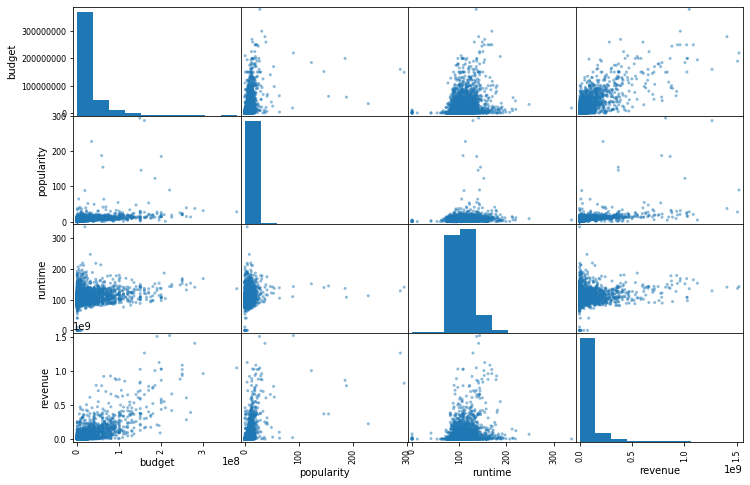

In [5]:
attributes = ["budget", "popularity", "runtime", "revenue"]
scatter_matrix(train[attributes], figsize=(12,8))

We plot the attributes in a scatter matrix. The only obvious correlation to be seen here is indeed ``revenue`` and ``budget``. 

However, ``revenue`` and ``popularity`` does not seem to correlated, which is surprising. Let's have a closer look at that relation:

(0, 180000000)

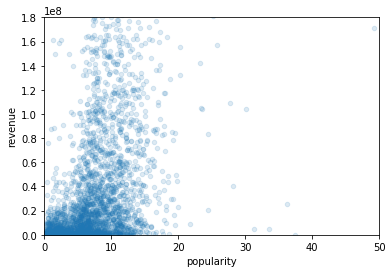

In [6]:
train.plot(kind="scatter", x="popularity", y="revenue", alpha=0.15)
plt.xlim(0,50)
plt.ylim(0,180000000)


This looks like a mess. One can see that movies with a popularity with less than "10" (whatever that number means) tend to not make too much money. There are exceptions to this though. 

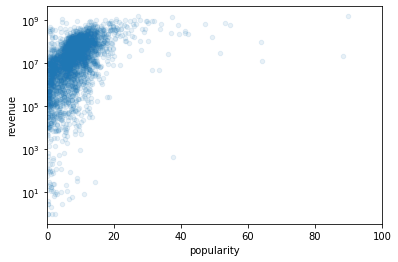

In [7]:
train.plot(kind="scatter", x="popularity", y="revenue", alpha=0.1)
plt.xlim(0,100)
plt.yscale("log")

Plotting it logarithmically looks a bit less messy, but it's hard to get useful info from this one too. The movies that are the most popular tend to have the highest revenue, with few exceptions.

It seems hard to get information from this attribute.

Let's also have a quick look at the ``budget`` and ``revenue`` correlation:

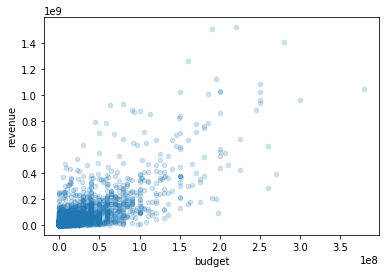

In [8]:
train.plot(kind="scatter", x="budget", y="revenue", alpha=0.2)

We can see that the budget value is often a round number. Patterns/lines are forming at the different million-marks. 

There is also a lot more correlation compared to popularity. 

But we also have to look at the columns that are not initially number types, and see if there are some other correlations with revenue. To do this, we have to prepare the data.

## Preparing the data

In [9]:
train_copy = train.copy()
test_copy = test.copy()

We make some copies and use them instead because we are a bit paranoid.

### belongs_to_collection and homepage

In [10]:
def collectionBooleanifier(collection):

    new_collection = []

    new_val = 0
    for x in collection:
        if x != x:
            new_val = 0
        else:
            new_val = 1
        new_collection.append(new_val) 
        
    return new_collection

In [11]:
train_copy['has_collection'] = collectionBooleanifier(train_copy['belongs_to_collection'])
train_copy['has_homepage'] = collectionBooleanifier(train_copy['homepage'])
test_copy['has_collection'] = collectionBooleanifier(test_copy['belongs_to_collection'])
test_copy['has_homepage'] = collectionBooleanifier(test_copy['homepage'])

train_copy = train_copy.drop(['belongs_to_collection'], axis=1)
train_copy = train_copy.drop(['homepage'], axis=1)
test_copy = test_copy.drop(['belongs_to_collection'], axis=1)
test_copy = test_copy.drop(['homepage'], axis=1)

The first data we replace is the collection objects. We decided to just check if a movie was a part of a collection or not. We thought we could make a new column for each unique collection and check if the movie was part of any (kinda like one hot encoding), but we were unsure if that would give more results and it seemed like a lot of work and extra columns for little gain. 

The function ``collectionBooleanifier`` could be used for both collection and homepage. 

Let's take a quick look at these new attributes:

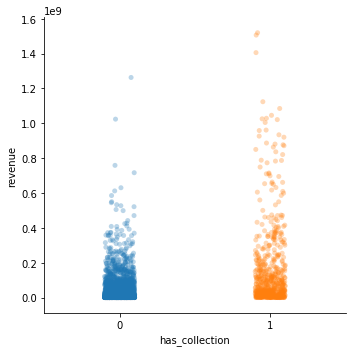

In [12]:
sns.catplot(x="has_collection", y="revenue", alpha=0.3, data=train_copy)

It looks like movies that are part of a collection have higher revenues. 

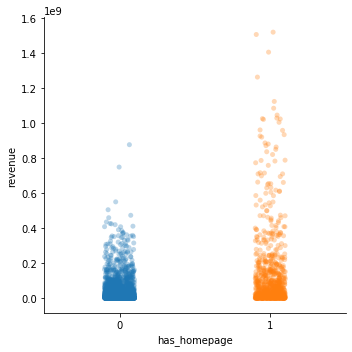

In [13]:
sns.catplot(x="has_homepage", y="revenue", alpha=0.3, data=train_copy)

Interestingly, the same can be said about hompage. Maybe this is because bigger movies tend to have homepages, but smaller movies don't?  

### Spoken language

Now let's look at the ``spoken_languages`` column

In [14]:
langs = train_copy['spoken_languages'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

Here we make a temporary list for practical purposes. This lambda expression goes through the list and converts the string representation of list of dictionaries into *actual* list of dictionaries.

In [15]:
print('Number of spoken languages in films')

langs.apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [16]:
list_of_languages = list(langs.apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

Looking at these data we can clearly see that there are many more movies in english than non-english. English is 10 times as popular as the second biggest language, french. 

Therefore, we decided to just have one variable ``has_english`` to replace spoken languages. This variable is ``1`` if the movie is in english (or has english spoken in it at all), and ``0`` otherwise.

In [17]:
def language_encoder(column, length):

    new_lang = [0] * length
    
    i = 0
    for x in column:
        if x == x:
            ds = ast.literal_eval(x)
            if any(d['iso_639_1'] == 'en' for d in ds): 
                new_lang[i] = 1
        else:
            new_lang[i] = 1 #if the movie doesn't specify spoken language we assume it's english, just by probability. 
        i+=1
    
    return new_lang

In [18]:
train_copy['has_english'] = language_encoder(train_copy['spoken_languages'], 3000)
test_copy['has_english'] = language_encoder(test_copy['spoken_languages'], 4398)

train_copy = train_copy.drop(['spoken_languages'], axis=1)
test_copy = test_copy.drop(['spoken_languages'], axis=1)

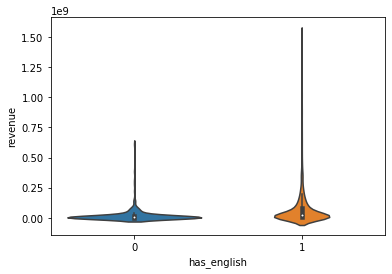

In [19]:
sns.violinplot(x="has_english", y="revenue", data=train_copy)

We see that the non-english movies tend to have lower revenue, while english movies vary a bit more. This makes sense, one could imagine that there is a bigger marked for movies in english.

### Cast and Crew

Next up is the cast and crew columns. First: let's open up these objects and check out what hides inside them!

In [26]:
ast.literal_eval(train_copy['cast'][0])

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'prof

In [27]:
ast.literal_eval(train_copy['crew'][0])

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36

In [28]:
ast.literal_eval(train_copy['Keywords'][0])

[{'id': 4379, 'name': 'time travel'},
 {'id': 9663, 'name': 'sequel'},
 {'id': 11830, 'name': 'hot tub'},
 {'id': 179431, 'name': 'duringcreditsstinger'}]

All these three columns are lists of dictionaries. That means there's a lot of data in each of them. Just looking at cast alone, there are lots of information for each actor. One could imagine some specific actors increasing the popularity of movies and therefore also revenue.

However, we didn't think we would gain much from adding individual columns for actors. Instead we thoguht the size of the cast and the gender-distribution of the cast were more interesting attributes, and thought these maybe had an impact on the revenue.

So we made a function that did that on cast:

In [29]:
def cast_counter(column):
    cast_size = [0] * len(column)
    male_cast_size = [0] * len(column)
    female_cast_size = [0] * len(column)
    uncategorized_cast_size = [0] * len(column)
    
    i = 0
    for cast_list_str in column:
        
        if cast_list_str == cast_list_str:
            cast_list = ast.literal_eval(cast_list_str)
            cast_size[i] = len(cast_list)
            
            for cast in cast_list:
                if(cast['gender'] == 1):
                    female_cast_size[i] += 1
                elif(cast['gender'] == 2):
                    male_cast_size[i] += 1
                else:
                    uncategorized_cast_size[i] += 1
            
        else:
            cast_size[i] = np.nan
            female_cast_size[i] = np.nan
            male_cast_size[i] = np.nan
            uncategorized_cast_size[i] = np.nan
        i+=1
    
    return cast_size, female_cast_size, male_cast_size, uncategorized_cast_size

In [30]:
train_copy['cast_size'], train_copy['female_cast_size'], train_copy['male_cast_size'], train_copy['uncategorized_cast_size'] = cast_counter(train_copy['cast'])
train_copy = train_copy.drop('cast', axis = 1)

test_copy['cast_size'], test_copy['female_cast_size'], test_copy['male_cast_size'], test_copy['uncategorized_cast_size'] = cast_counter(test_copy['cast'])
test_copy = test_copy.drop('cast', axis = 1)

### Attribute lengths and sizes

We also wanted a function that makes a new column with the number of objects in a list from another column. 

In [38]:
def attribute_counter(column):
    attribute_size = [0] * len(column)
    
    i = 0
    for attribute_list_str in column:
        
        if attribute_list_str == attribute_list_str:
            attribute_list = ast.literal_eval(attribute_list_str)
            attribute_size[i] = len(attribute_list)           
        else:
            attribute_size[i] = np.nan
        i+=1
    
    return attribute_size

In [39]:
def attribute_length(column, length) :
    new_column = [0] * length
    
    i = 0
    for data_attribute in column:
        if data_attribute == data_attribute:
            new_column[i] = len(data_attribute)
        else:
            new_column[i] = np.nan
        i += 1       
        
    return new_column        

These functions were simple to make, and they might give the algorithm some more usable numbers to work with.

In [40]:
train_copy['title_length'] = attribute_length(train_copy['title'], 3000)
train_copy['tagline_length'] = attribute_length(train_copy['tagline'], 3000)
train_copy['crew_size'] = attribute_counter(train_copy['crew'])
train_copy['num_keywords'] = attribute_counter(train_copy['Keywords'])

test_copy['title_length'] = attribute_length(test_copy['title'], 4398)
test_copy['tagline_length'] = attribute_length(test_copy['tagline'], 4398)
test_copy['crew_size'] = attribute_counter(test_copy['crew'])
test_copy['num_keywords'] = attribute_counter(test_copy['Keywords'])

### Genres

In [ ]:
#Get all names for the genres
def namesOfGenres(collection):
    temp = []
    for l in collection:
        if l == l:
            a = ast.literal_eval(l)
            for x in a:
                text = {'id': x['id'], 'name': x['name']}
                if text not in temp:
                    temp.append(text)
    return temp
    
namesR = namesOfGenres(train_copy['genres'])
namesE = namesOfGenres(test_copy['genres'])

In [ ]:
#onehot per row

def genresToInt(_collection, names_collection):
    genres_temp = []
    for l in _collection:
        res =  [0] * len(names_collection)
        
        if l == l:
            a = ast.literal_eval(l)
            for i in range(0, len(names_collection)):
                for g in a:
                    if g == names_collection[i]:
                        res[i] = 1
        
        genres_temp.append(res)
    return genres_temp
                        
genresR = genresToInt(train_copy['genres'], namesR)
genresE = genresToInt(test_copy['genres'], namesE)

In [ ]:
#Create colloms

def createCollomnDown2D(name, arr, index, data):
    newArr = []
    for row in arr:
        newArr.append(row[index])
    
    data[name] = newArr

def createCollomnDownInCollection(collection, names_collection, genres_collection):
    for i in range(0, len(names_collection)):
        createCollomnDown2D("has_genre_" + names_collection[i]['name'].replace(" ", "_").lower(), 
                            genres_collection, 
                            i, 
                            collection)
        
createCollomnDownInCollection(train_copy, namesR, genresR)
createCollomnDownInCollection(test_copy, namesE, genresE)

train_copy['has_genre_drama']

In [ ]:
train_copy['release_date']

In [ ]:
def release_date_conv(collection, length):
    month = []
    year = []

    for t in collection['release_date']:
        if t == t:
            split_arr = t.split('/')
            month.append(int(split_arr[0]))

            yearInt = int(split_arr[2])
            if(yearInt < 20):
                year.append(2000 + yearInt)
            else:
                year.append(1900 + yearInt)
        else:
            #FIX ME
            month.append(10)
            year.append(2000)
        
    while len(month) < length:
        month.append(0)
        year.append(0)
    
    collection['release_month'] = month
    collection['release_year'] = year
    
    collection = collection.drop(['release_date'], axis=1)
        
release_date_conv(train_copy, 3000)
release_date_conv(test_copy, 4398)

In [ ]:
train_copy.plot(kind="scatter", x="release_year", y="popularity", alpha=0.2)
plt.xlim(1980, 2020)

In [ ]:


# remove old genre collomn
train_copy = train_copy.drop(['release_date'], axis=1)
train_copy = train_copy.drop(['genres'], axis=1)
train_copy = train_copy.drop(['imdb_id'], axis=1)
train_copy = train_copy.drop(['original_language'], axis=1)
train_copy = train_copy.drop(['poster_path'], axis=1)
train_copy = train_copy.drop(['has_genre_tv_movie'], axis=1)

test_copy = test_copy.drop(['release_date'], axis=1)
test_copy = test_copy.drop(['genres'], axis=1)
test_copy = test_copy.drop(['imdb_id'], axis=1)
test_copy = test_copy.drop(['original_language'], axis=1)
test_copy = test_copy.drop(['poster_path'], axis=1)

In [ ]:
def runtime_onehot(collection, length):
    newRuntimes = []
    for x in train_copy['runtime']:
        if x == x:
            newRuntimes.append(int(x))
        else:
            newRuntimes.append(0)
    
    while len(newRuntimes) < length:
        newRuntimes.append(0)

    collection['runtime'] = newRuntimes

In [ ]:
runtime_onehot(train_copy, 3000)
runtime_onehot(test_copy, 4398)

In [ ]:
def status_one_hot(collection):
    statusOnehot = []
    for movie in collection['status']:
        if movie is "Released":
            statusOnehot.append(1)
        else:
            statusOnehot.append(0)
    return statusOnehot

In [ ]:
train_copy['status'] = status_one_hot(train_copy)
test_copy['status'] = status_one_hot(test_copy)

In [ ]:
train_copy = train_copy.drop(['overview'], axis=1)
train_copy = train_copy.drop(['production_countries'], axis=1)
train_copy = train_copy.drop(['tagline'], axis=1)
train_copy = train_copy.drop(['title'], axis=1)
train_copy = train_copy.drop(['Keywords'], axis=1)
train_copy = train_copy.drop(['crew'], axis=1)
train_copy = train_copy.drop(['original_title'], axis=1)
train_copy = train_copy.drop(['production_companies'], axis=1)

test_copy = test_copy.drop(['overview'], axis=1)
test_copy = test_copy.drop(['production_countries'], axis=1)
test_copy = test_copy.drop(['tagline'], axis=1)
test_copy = test_copy.drop(['title'], axis=1)
test_copy = test_copy.drop(['Keywords'], axis=1)
test_copy = test_copy.drop(['crew'], axis=1)
test_copy = test_copy.drop(['original_title'], axis=1)
test_copy = test_copy.drop(['production_companies'], axis=1)

In [ ]:
train_copy = train_copy.fillna(train_copy.median())
test_copy = test_copy.fillna(train_copy.median())

In [ ]:
train_copy.info()

In [ ]:
test_copy.info()

In [ ]:
corr_matrix = train_copy.corr()
corr_matrix["revenue"].sort_values(ascending=False)

In [ ]:
revenues = train['revenue'].copy()
train_copy_no_rev = train_copy.drop(['revenue'], axis=1)

## Transformation stuff

In [ ]:
imputer = SimpleImputer(strategy="median")
imputer.fit(train_copy_no_rev)

In [ ]:
imputer.statistics_

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_copy_tr = num_pipeline.fit_transform(train_copy_no_rev)

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
    ])

In [ ]:
train_prepared = full_pipeline.fit_transform(train_copy_no_rev)
train_prepared[3]

## Selecting and train a model

In [ ]:
train_no_revenue = train_copy_no_rev.copy()

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_prepared, train_copy)

In [ ]:
scores = cross_val_score(tree_reg, train_prepared, train_copy, 
                         scoring="neg_mean_squared_log_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train_prepared, train_copy)
train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(train_copy, train_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_rmse

In [ ]:
forest_scores = cross_val_score(forest_reg, train_prepared, train_copy,
                             scoring="neg_mean_squared_log_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

In [ ]:
param_distribs = {
        'n_estimators': randint(low=30, high=36),
        'max_features': randint(low=4, high=35),
}

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_no_revenue, revenues)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
rnd_search.best_estimator_

In [ ]:
final_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=11, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
final_model.fit(train_no_revenue, revenues)


In [ ]:
train_copy.info()

In [ ]:
forest_rmse_scores

## Evaluating system on test set

In [ ]:
test_copy.head()

In [ ]:
train_copy.shape

In [ ]:
X_test = test_copy

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

In [ ]:
subm = pd.DataFrame({'id': test.id, 'revenue': final_predictions})

In [ ]:
pd.DataFrame(subm).to_csv("thirdTestSubmissionRFG.csv", index=False)

### XGBoost (not implemented)

In [ ]:
?train_test_split

In [ ]:
X = train_copy.drop(['revenue'], axis = 1)
y = train_copy.revenue.apply(np.log1p)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

In [ ]:
params = {'objective': 'reg:linear', 
          'eta': 0.01, 
          'max_depth': 6, 
          'min_child_weight': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'colsample_bylevel': 0.50, 
          'gamma': 1.45, 
          'eval_metric': 'rmse', 
          'seed': 12, 
          'silent': True    
}

In [ ]:
xgb_data = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]

In [ ]:
print('Starting training...')
# train
xgb_model = xgb.train(params, 
                  xgb.DMatrix(X_train, y_train),
                  5000,  
                  xgb_data, 
                  verbose_eval=200,
                  early_stopping_rounds=200)
print('Done:)')

In [ ]:
xgb_model_full = xgb.XGBRegressor(objective  = 'reg:linear', 
          eta = 0.01, 
          max_depth = 6,
          min_child_weight = 3,
          subsample = 0.8, 
          colsample_bytree = 0.8,
          colsample_bylevel = 0.50, 
          gamma = 1.45, 
          eval_metric = 'rmse',
          seed = 12, n_estimators = 2000)

In [ ]:
xgb_model_full.fit (X.values, y)

In [ ]:
X_test = test_copy
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test_data.id, 'revenue': xgb_pred}).to_csv('xgbsubmission.csv', index=False)

##### TODO list:
 - [ ] Skrive mer om exploring of data og 
 - [ ] ukedag-attributt(?) 
 - [x] size of cast
 - [x] gender of main character
 - [x] length of title
 - [x] num of keywords
 - [x] size of crew
 - [ ] attributter for kjente skuespillere,  attributter som bruker crew (?) f.eks. navn på regissør, antall exec. producers eller has_set_designer (?),  eller attributt som sier noe om production company (?)
 - [x] fiks alle kolonner som mangler data (fyll med medianverdier?)
 - [x] **fiks alle budget-verdier som er 0. (Kanskje gjør dem til median?)** (dette hjalp ikke)
 - [ ] Prøve Light Gradient Boosting Machine eller XGBoost istedenfor RandomForest